## EX07

# Generating CFPy-ready network structures with (1) pyKasso and (2) from general network information - PART II: advanced network generation

In [1]:
import CFPy as cfpy
import pykasso as pk
import matplotlib.pyplot as plt
import numpy as np
import os

# 0. Show Versions

In [2]:
%load_ext watermark

In [3]:
%watermark

Last updated: 2023-02-21T18:42:39.836046+01:00

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 4, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [4]:
%watermark --iversions

matplotlib: 3.5.2
CFPy      : 0.1
numpy     : 1.22.4
pykasso   : 0.1.0



## 1. Generating CFPy-ready network structures with pyKasso

In [5]:
# create a catchment from the information given in settings.yaml
catchment = pk.SKS(yaml_settings_file="settings4.yaml")

CAUTION: You are using the development version of this package.


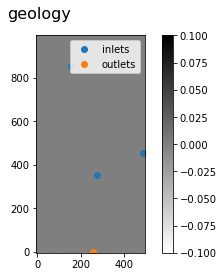

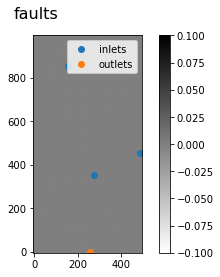

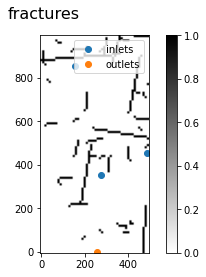

In [6]:
# get data for geology, faluts, and fractures as arrays
geology = catchment.get_geology()
faults = catchment.get_faults()
fractures = catchment.get_fractures()

# show maps of geology, faults, and fractures
catchment.show_catchment(data='geology')
catchment.show_catchment(data='faults')
catchment.show_catchment(data='fractures')


 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


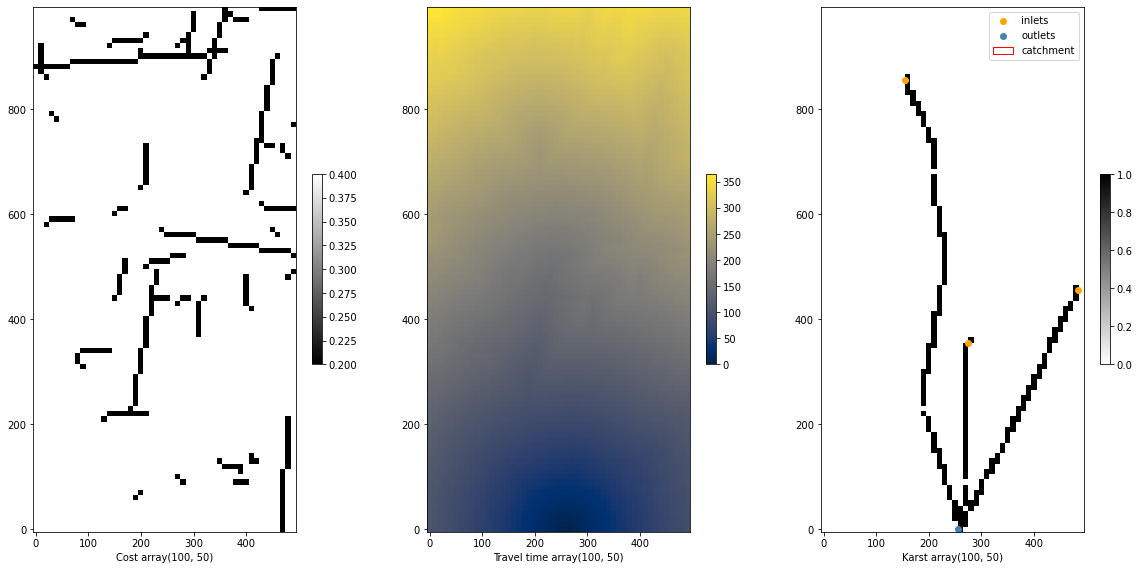

In [7]:
# compute karst networks from the given information
catchment.compute_karst_network()

# show the result of the last iteration (the last karst network)
catchment.show(probability=False)

### Make the network quasi-3D (i.e., rotate the plane the network is in)


Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.


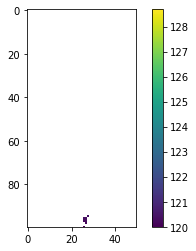

In [8]:
# generate elevation data (providing elevation data for the nodes is optional)
# NOTE: elevation data has to have the same shape as the node network array!

# get shape
domain_shape = np.shape(np.array(catchment.karst_simulations[-1].maps['karst'][-1]))
# make linearly spaced values along a single column
elevs = np.linspace(130., 120., domain_shape[0], endpoint=True)
# repeat values and reshape to desired shape
elevs = np.repeat(elevs, domain_shape[1], 0).reshape(domain_shape)

# validate the network
validator = cfpy.preprocessing.pyKassoValidator(network=catchment, elevations=elevs)
valid_network = validator.validate_network()

# plot the network and mask 0.-values (they would mess up the coloring)
im = plt.imshow(np.where(valid_network == 0., np.nan, valid_network))
plt.colorbar(im)

In [9]:
# export the network
# the exported information can directly be included in the .nbr-file as input for CFPy
# notes on how to use the generated data with CFPy is given at the end of the notebook
# per default, the network is exported to "CFPy_exported_network_for_NBR.txt" in the active directory
validator.export_network()

## 2. Generating CFPy-ready network structures from an existing array for a network structure

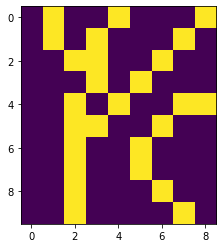

In [10]:
# an existing array for the node network structure
# 1 represents a node, 0 represents a matrix cell
# here, we have two node planes on top of each other
a = np.array([[
              [0., 1., 0., 0., 1., 0., 0., 0., 1.],
              [0., 1., 0., 1., 0., 0., 0., 1., 0.],
              [0., 0., 1., 1., 0., 0., 1., 0., 0.],
              [0., 0., 0., 1., 0., 1., 0., 0., 0.],
              [0., 0., 1., 0., 1., 0., 0., 1., 1.],
              [0., 0., 1., 1., 0., 0., 1., 0., 0.],
              [0., 0., 1., 0., 0., 1., 0., 0., 0.],
              [0., 0., 1., 0., 0., 1., 0., 0., 0.],
              [0., 0., 1., 0., 0., 0., 1., 0., 0.],
              [0., 0., 1., 0., 0., 0., 0., 1., 0.]],
             [[0., 1., 0., 0., 1., 0., 0., 0., 1.],
              [0., 1., 0., 1., 0., 0., 0., 1., 0.],
              [0., 0., 1., 1., 0., 0., 1., 0., 0.],
              [0., 0., 0., 1., 0., 1., 0., 0., 0.],
              [0., 0., 1., 0., 1., 0., 0., 1., 1.],
              [0., 0., 1., 1., 0., 0., 1., 0., 0.],
              [0., 0., 1., 0., 0., 1., 0., 0., 0.],
              [0., 0., 1., 0., 0., 1., 0., 0., 0.],
              [0., 0., 1., 0., 0., 0., 1., 0., 0.],
              [0., 0., 1., 0., 0., 0., 0., 1., 0.]]
])

# elevation data for the nodes
elev = np.ones_like(a)
elev[0, :, :] = elev[0, :, :] * 125.
elev[1, :, :] = elev[1, :, :] * 20.

# show the "raw" network, which has diagonally adjacent nodes
# the diagonally adjacent nodes will be handled by the validator
plt.imshow(a[0, :, :])


Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.

Always visually check the validated network for structuralcorrectness! 
i.e., whether branches are correctly isolated or ifthey got connected during processing.


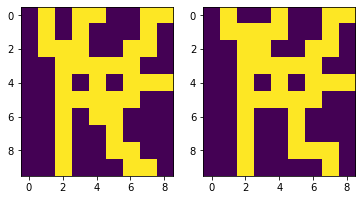

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=2)

valid_networks = []

j = 0
for i in zip(a, elev):
    validator = cfpy.preprocessing.GeneralValidator(network=i[0], elevations=i[1])
    valid_network = validator.validate_network()
    valid_networks.append(valid_network)
    
    # export the network
    # the exported information can directly be included in the .nbr-file as input for CFPy
    # notes on how to use the generated data with CFPy is given at the end of the notebook
    path = os.path.join(os.getcwd(), "network_plane_{}.txt".format(j))
    validator.export_network(path)
    
    ax[j].imshow(valid_network)
    
    if j == 0:
        validator.generate_nbr(path=None, nplanes=2, nrows=10, ncols=9, nlays=1, layer_elevations=[[150.], [0.]])
    
    j += 1

In [12]:
# put second node plane in the .nbr file (at the moment, there is only one plane)
with open("CFPy_nbr.nbr", "a") as f:
    f.write("#\n")
    for i in valid_networks[1]:
        for j in i:
            if j == 0.:
                f.write(str(-999) + " ")
            else:
                f.write(str(j) + " ")
        f.write("\n")

## 3. Adding a vertical connection in the .nbr file

In [13]:
# read the nbr file
with open("CFPy_nbr.nbr", "r+") as f:
    lines = f.readlines()
    
# write the new line / add the vertical connection
# we know that we want to add the connection in the third row in the third column
# this line is always at line index 10 and 21 in the .nbr file for the two node planes, respectively
# modify plane1
line = lines[9].split()
line[2] = "c125.00"
line.append("\n")
lines[9] = " ".join(line)
print(lines[9])
# modify plane2
line = lines[20].split()
line[2] = "c20.00"
line.append("\n")
lines[20] = " ".join(line)
print(lines[20])

# write the file again
with open("CFPy_nbr.nbr", "w+") as f:
    f.writelines(lines)

-999 125.00 c125.00 125.00 -999 -999 125.00 125.00 -999 

-999 -999 c20.00 20.0 -999 -999 20.0 20.0 -999 



Elapsed time (.nbr file read): 0.0 s
Elapsed time (write nbr data): 0.03 s


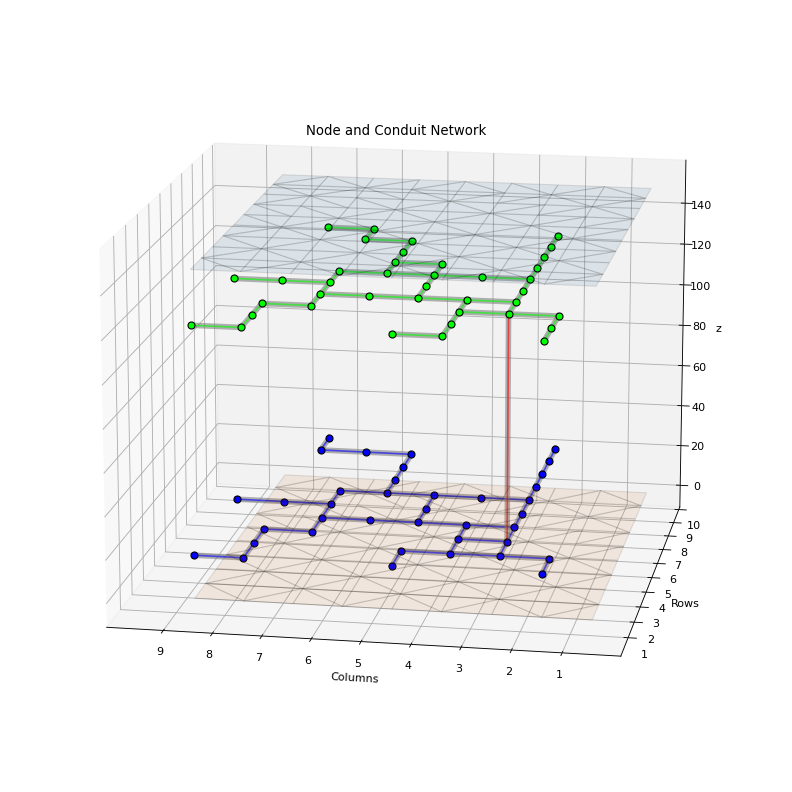

In [14]:
# look at the network

nbr = cfpy.nbr()
bot_elev, cond_elev = nbr.nbr_read()

# create nbr-data
nbr_data = nbr.nbr(bot_elev, cond_elev)

network = cfpy.plots.Network(elevs=[bot_elev, cond_elev], nbr_data=nbr_data)
plot = network.plot_network(text_shift=0.1, dpi=80, rot_x=15, rot_z=-80, plot_nums=False, kind="triangular")